In [1]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import tempfile
tmpdir=tempfile.gettempdir()
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from PIL import Image

#from profile_surface import surface_smoothing

In [2]:
def surface_smoothing(values, surf_filename, fwhm=2):
    """smooth surface values using depth_potential. Will loop over multiple values if necessary
    smooths across surf_filename with fwhm set"""
    #check dimensions
    shrink=False
    flipped=False
    if np.ndim(values)==1:
        values=np.array([values])
        shrink=True
    elif values.shape[0]>values.shape[1]:
        values=values.T
        flipped=True
    new_values=np.zeros_like(values)
    for k,overlay in enumerate(values):
        np.savetxt('/tmp/tmp.txt', overlay, fmt='%.2f')
        print('smoothing surface '+str(k))
        subprocess.call('depth_potential -smooth '+ str(fwhm)+' /tmp/tmp.txt '+ surf_filename + ' /tmp/smtmp.txt',shell=True)
        new_overlay = np.loadtxt('/tmp/smtmp.txt')
        new_values[k] = new_overlay
    if shrink:
        return new_values[0]
    else:
        if flipped==True:
            return new_values.T
        return new_values

In [9]:
def plot_surface(overlay,surface_file,colourmap,min_val,max_val, mask=False, hemi='right'):
    import io_mesh as io
    """ plot surface overlays using ray_trace,
    colourmap is matplotlib colourmap
    surface_file is obj file
    min_val and max_val have to be specified
    hemi is used for view"""
    if mask is not False:
        overlay[mask==1]=min_val-0.01
    #save two views
    surface=io.load_mesh_geometry(surface_file)
    colours=overlay2colours(overlay,colourmap,min_val,max_val)
    save_coloured_obj(os.path.join(tmpdir,'tmp.obj'),surface['coords'],surface['faces'],colours)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, 'tmp.obj ' ) +'-bg white -sup 3 -crop -'+hemi+' -size 1000 1000 -output ' +  os.path.join(tmpdir, 'tmp_l.rgb' ),shell=True)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, 'tmp.obj ' ) +'-bg white -sup 3 -crop -back -size 1000 1000 -output ' +  os.path.join(tmpdir, 'tmp_r.rgb' ),shell=True)
    imagel=plt.imread( os.path.join(tmpdir, 'tmp_l.rgb' ))
    imager=plt.imread( os.path.join(tmpdir, 'tmp_r.rgb' ))
    return imagel,imager

def rescale_to_256(array,min_val,max_val):
    """ensure all values lie in range 0 - 255"""
    scaled=(array-min_val)/(max_val-min_val)
    #clip
    array_s=np.round(255*scaled).astype(int)
    return array_s

def rgb_matrix(cmap_name):
    colourmap=cm.get_cmap(cmap_name)
    c=np.zeros((256,4))
    for r in range(256):
        c[r]=list(colourmap(r))
    return c

def save_coloured_obj(surf_mesh,coords,faces,colours):
    """save obj file with coloured vertices
    surfmesh - filename obj
    coords - coordinates
    faces - triangle indices
    colours - n_vert x 4 matrix of colours rgb"""
#write out MNI - obj format
    n_vert=len(coords)
    norms=normal_vectors(coords,faces).tolist()
    XYZ=coords.tolist()
    Tri=faces.tolist()
    with open(surf_mesh,'w') as s:
        line1="P 0.3 0.3 0.4 10 1 " + str(n_vert) + "\n"
        s.write(line1)
        k=-1
        #save coordinates
        for a in XYZ:
            k+=1
            cor=' ' + ' '.join(list(map(str, XYZ[k])))
            s.write('%s\n' % cor)
        s.write('\n')
        #save normals
        for k,a in enumerate(XYZ):
            normal=' ' + ' '.join(list(map(str, norms[k])))
            s.write('%s\n' % normal)
        s.write('\n')
        l=' ' + str(len(Tri))+'\n'
        s.write(l)
        #2 indicates colours are done per vertex
        s.write(' 2\n')
        for colour in colours:
            col=' ' + ' '.join(list(map(str, colour)))
            s.write('%s\n' % col)
        s.write('\n')
        nt=len(Tri)*3
        Triangles=np.arange(3,nt+1,3)
        Rounded8=np.shape(Triangles)[0]/8
        N8=int(8*Rounded8)
        Triangles8=Triangles[0:N8]
        RowsOf8=np.split(Triangles8,N8/8)
        for r in RowsOf8:
            L=r.tolist()
            Lint=map(int,L)
            Line=' ' + ' '.join(map(str, Lint))
            s.write('%s\n' % Line)
        L=Triangles[N8:].tolist()
        Lint=map(int,L)
        Line=' ' + ' '.join(map(str, Lint))
        s.write('%s\n' % Line)
        s.write('\n')
        ListOfTriangles=np.array(Tri).flatten()
        Rounded8=np.shape(ListOfTriangles)[0]/8
        N8=int(8*Rounded8)
        Triangles8=ListOfTriangles[0:N8]
        ListTri8=ListOfTriangles[0:N8]
        RowsOf8=np.split(Triangles8,N8/8)
        for r in RowsOf8:
            L=r.tolist()
            Lint=map(int,L)
            Line=' ' + ' '.join(map(str, Lint))
            s.write('%s\n' % Line)
        L=ListOfTriangles[N8:].tolist()
        Lint=map(int,L)
        Line=' ' + ' '.join(map(str, Lint))
        s.write('%s\n' % Line)
        
        
def normal_vectors(vertices,faces):
    norm = np.zeros( vertices.shape, dtype=vertices.dtype )
    tris = vertices[faces]
    n = np.cross( tris[::,1 ] - tris[::,0]  , tris[::,2 ] - tris[::,0] )
    n=normalize_v3(n)
    norm[ faces[:,0] ] += n
    norm[ faces[:,1] ] += n
    norm[ faces[:,2] ] += n
    return normalize_v3(norm)


def normalize_v3(arr):
    ''' Normalize a numpy array of 3 component vectors shape=(n,3) '''
    lens = np.sqrt( arr[:,0]**2 + arr[:,1]**2 + arr[:,2]**2 )
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens                
    return arr

def overlay2colours(overlay,colourmap, min_val, max_val):
    """colour each vertex in an overlay
    below min_val is set to white (0,0,0,0). Above is clipped to max_val"""
    overlay_s=rescale_to_256(overlay,min_val,max_val)
    colours = rgb_matrix(colourmap)
    overlay_rgb=np.zeros((len(overlay),4))
    #set below thresh colours to white
    overlay_rgb[overlay_s<0]=np.array([1,1,1,1])
    overlay_s=np.clip(overlay_s, None, 255).astype(int)
    overlay_rgb[overlay_s>=0]=colours[overlay_s[overlay_s>=0]]
    return overlay_rgb


In [10]:
bar=np.reshape(rgb_matrix('magma'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)


In [ ]:
hemis=['right','left']
ncol=4
nrow=3
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), #height_ratios=[1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)
min_val=0.3
max_val=0.9
for k,hemi in enumerate(hemis):
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_layer4.txt')[:163842]
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')
    overlay=surface_smoothing(overlay, surface_file,2)
    surface_plots = plot_surface(overlay, surface_file,'magma',mask=mask, min_val=min_val, max_val=max_val, hemi=hemi)
    ax= plt.subplot(gs[k,0:2])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')
    ax= plt.subplot(gs[k,2:4])
    ax.imshow(surface_plots[1-np.abs(k-1)])
    ax.axis('off')

ax= plt.subplot(gs[2,1:3])
ax.imshow(np.rot90(bar))
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(min_val,decimals=2),np.mean([min_val,max_val]),np.round(max_val,decimals=2)],size=25)
ax.set_title('Cortical thickness (mm)', size=25)
#fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/total_thickness.pdf')

smoothing surface 0


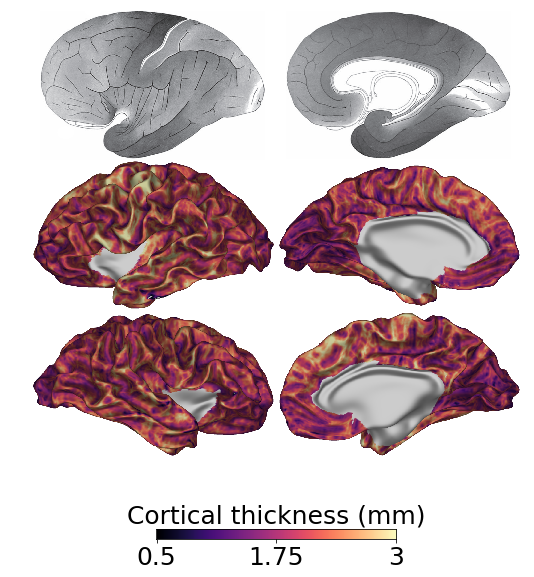

In [8]:
hemis=['left','right']
ncol=4
nrow=4
fig = plt.figure(figsize=(10, 11)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), #height_ratios=[1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)
min_val=0.5
max_val=3
ve_lat=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Total_thickness_lateral.tiff')
ve_med=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Total_thickness_medial.tiff')
ax= plt.subplot(gs[0,0:2])
ax.imshow(ve_lat)
ax.axis('off')
ax= plt.subplot(gs[0,2:4])
ax.imshow(ve_med)
ax.axis('off')

for k,hemi in enumerate(hemis):
    overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')
    #overlay=surface_smoothing(overlay, surface_file,3)
    surface_plots = plot_surface(overlay, surface_file,'magma',mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[k+1,0:2])
    ax.imshow(surface_plots[1-np.abs(k-1)])
    ax.axis('off')
    ax= plt.subplot(gs[k+1,2:4])
    ax.imshow(surface_plots[np.abs(k-1)])
    ax.axis('off')

ax= plt.subplot(gs[3,1:3])
ax.imshow(np.rot90(bar))
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(min_val,decimals=2),np.mean([min_val,max_val]),np.round(max_val,decimals=2)],size=25)
ax.set_title('Cortical thickness (mm)', size=25)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/total_thickness_plus_ve.pdf',bbox_inches='tight')

0 0
smoothing surface 0
smoothing surface 0
4 0
smoothing surface 0
smoothing surface 0
8 0
smoothing surface 0
smoothing surface 0
0 3
smoothing surface 0
smoothing surface 0
4 3
smoothing surface 0
smoothing surface 0
8 3
smoothing surface 0
smoothing surface 0


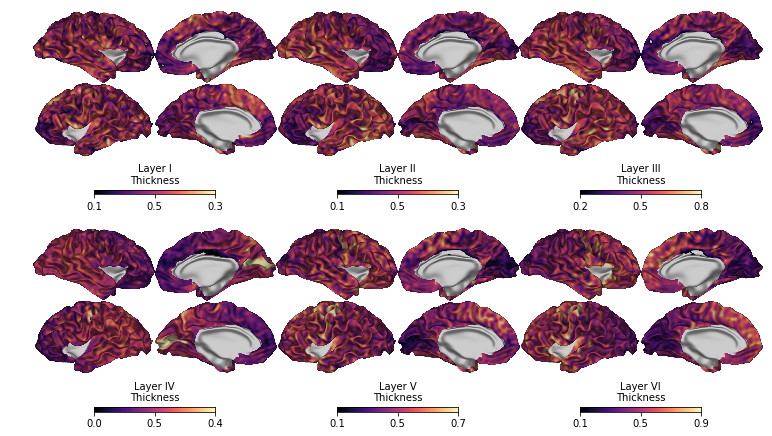

In [12]:
ncol=12
nrow=6
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(nrow, ncol,  #height_ratios=[10,1,10,1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)
gs.update(wspace=0, hspace=0)

#all_overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt')[:163842]
titles=[
    
    'Layer I',
    'Layer II',
    'Layer III',
    'Layer IV',
    'Layer V',
    'Layer VI',
]

for layer in range(6):
    c=4*(layer%3)
    ro=3*(layer//3)
    print(c,ro)
    for k,hemi in enumerate(hemis):
        overlay=overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_left_layer'+str(layer+1)+'.txt')[:163842]
        surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
        mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')   
        overlay=surface_smoothing(overlay, surface_file,3)
        if k ==0:
            mu=np.mean(overlay[mask!=1])
            sigma=np.std(overlay[mask!=1])
            min_val=mu-3*sigma
            max_val=mu+3*sigma    
        surface_plots = plot_surface(overlay, surface_file,'magma',mask=mask, min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[ro+k,c:c+2])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')
        ax= plt.subplot(gs[ro+k,c+2:c+4])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')
    
    ax= plt.subplot(gs[ro+2,c+1:c+3])
    ax.imshow(np.rot90(bar))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,128,256])
    ax.set_xticklabels([np.round(min_val,decimals=1),0.5,np.round(max_val,decimals=1)] ,size=10)
    ax.set_title(titles[layer]+'\nthickness (mm)', size=10)
    
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_thickness.pdf')


0 0
smoothing surface 0
smoothing surface 0
4 0
smoothing surface 0
smoothing surface 0
8 0
smoothing surface 0
smoothing surface 0
0 4
smoothing surface 0
smoothing surface 0
4 4
smoothing surface 0
smoothing surface 0
8 4
smoothing surface 0
smoothing surface 0


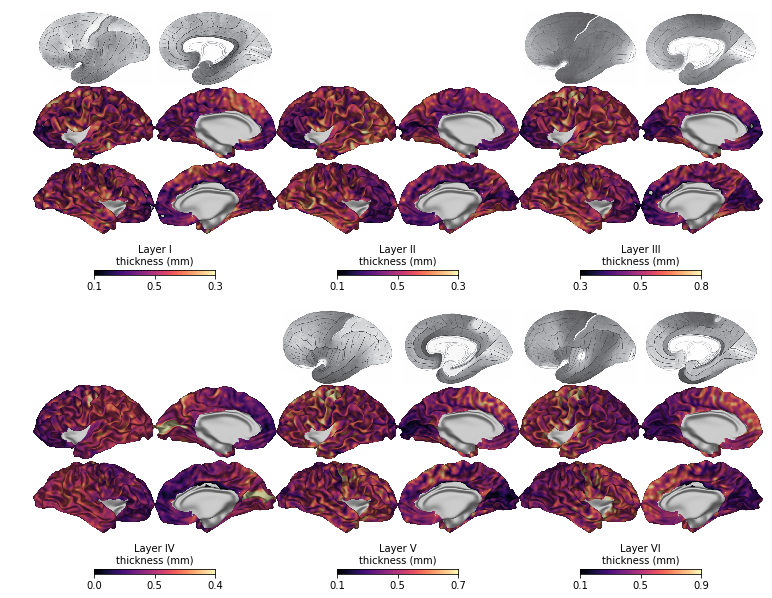

In [9]:

ncol=12
nrow=8
fig = plt.figure(figsize=(15, 11)) 
gs = gridspec.GridSpec(nrow, ncol,  #height_ratios=[10,1,10,1],
         wspace=0.05, hspace=0.04, left=0.17, right=0.845)
#gs.tight_layout(fig)
gs.update(wspace=0, hspace=0)

#all_overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt')[:163842]
titles=[
    
    'Layer I',
    'Layer II',
    'Layer III',
    'Layer IV',
    'Layer V',
    'Layer VI',
]

for layer in range(6):
    c=4*(layer%3)
    ro=4*(layer//3)
    print(c,ro)
    if os.path.isfile('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff'):
        ve_lat=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff')
        ve_med=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_medial.tiff')
        ax= plt.subplot(gs[ro,c:c+2])
        ax.imshow(ve_lat)
        ax.axis('off')
        ax= plt.subplot(gs[ro,c+2:c+4])
        ax.imshow(ve_med)
        ax.axis('off')
    for k,hemi in enumerate(hemis):
        overlay=overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_left_layer'+str(layer+1)+'.txt')[:163842]
        surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
        mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')   
        overlay=surface_smoothing(overlay, surface_file,3)
        if k ==0:
            mu=np.mean(overlay[mask!=1])
            sigma=np.std(overlay[mask!=1])
            min_val=mu-3*sigma
            max_val=mu+3*sigma    
        surface_plots = plot_surface(overlay, surface_file,'magma',mask=mask, min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[ro+k+1,c:c+2])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')
        ax= plt.subplot(gs[ro+k+1,c+2:c+4])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')
    
    ax= plt.subplot(gs[ro+3,c+1:c+3])
    ax.imshow(np.rot90(bar))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,128,256])
    ax.set_xticklabels([np.round(min_val,decimals=1),0.5,np.round(max_val,decimals=1)] ,size=10)
    ax.set_title(titles[layer]+'\nthickness (mm)', size=10)
    
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_thickness_plus_vonE.pdf',bbox_inches='tight')


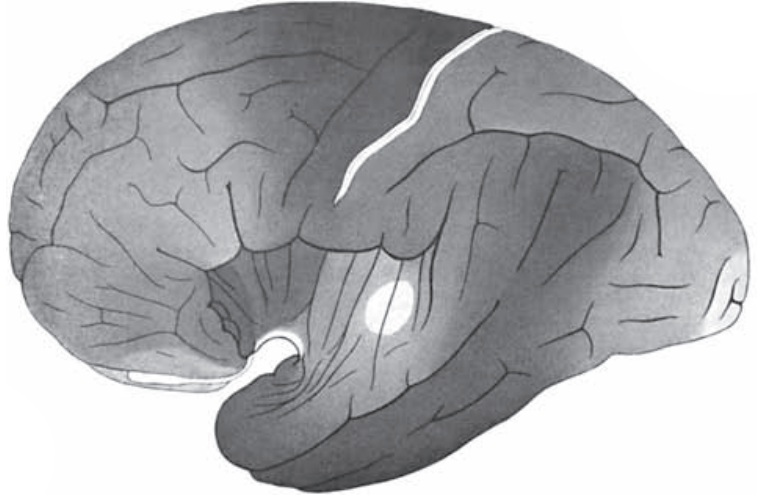

In [17]:
ve_lat=Image.open('/data1/users/kwagstyl/bigbrain/Hierarchy/Layer'+str(layer+1)+'_lateral.tiff')
ve_lat.show

In [15]:
from PIL import Image